In [1]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from keras import regularizers

In [4]:
path = './dogscats/'
batch_size = 32

# ===== Precompute ResNet Features =====#

In [10]:
def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory(path+'train', image_size, shuffle=False, 
                                              batch_size=batch_size)
    valid_generator = gen.flow_from_directory(path+'valid', image_size, shuffle=False, 
                                              batch_size=batch_size)

    train = model.predict_generator(train_generator, train_generator.samples//train_generator.batch_size+1)
    valid = model.predict_generator(valid_generator, valid_generator.samples//valid_generator.batch_size+1)
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("valid", data=valid)
        h.create_dataset("label", data=train_generator.classes)
        h.create_dataset("val_label", data=valid_generator.classes)

In [11]:
%time write_gap(ResNet50, (224, 224))

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
CPU times: user 6min 3s, sys: 34.4 s, total: 6min 38s
Wall time: 8min 43s


# Define Focal Loss Function#

Input: predicted label, true_label

Output: weight factor (1D numpy array) for each sample, which will be passed to sample_weight in model.fit()

From https://github.com/fchollet/keras/blob/master/keras/models.py#L828

        sample_weight: Numpy array of weights for
                the training samples, used for scaling the loss function
                (during training only). You can either pass a flat (1D)
                Numpy array with the same length as the input samples
                (1:1 mapping between weights and samples),
                or in the case of temporal data,
                you can pass a 2D array with shape (samples, sequence_length),
                to apply a different weight to every timestep of every sample.
                In this case you should make sure to specify
                sample_weight_mode="temporal" in compile().

In [5]:
def get_FL_weights(y_pred, y_train, alpha=0.25, gamma=2.):
    num_sample = y_pred.shape[0]
    weight_FL = np.zeros(num_sample)
    
    # get pt
    for i in range(num_sample):
        if y_pred[i]>=0.5 and y_train[i]==1:
            pt = y_pred[i]
        elif y_pred[i]<=0.5 and y_train[i]==0:
            pt = 1 - y_pred[i]
        elif y_pred[i]>=0.5 and y_train[i]==0:
            pt = 1 - y_pred[i]
        elif y_pred[i]<=0.5 and y_train[i]==1:
            pt = y_pred[i]
    
        weight_FL[i] = alpha * (1 - pt)**(gamma)
    
    return weight_FL   

def get_val_acc(y_true, y_pred):
    count = {}
    correct_count = {}
    num_correct_samples = 0
    num_samples = y_pred.shape[0]
    
    for i in range(num_samples):
        label = y_true[i]
        if y_pred[i] >=0.5:
            pred_label = 1
        else:
            pred_label = 0
        count[label] = count.get(label,0) + 1
        if pred_label == label:
            correct_count[label] = correct_count.get(label,0) + 1
            num_correct_samples += 1
    
    val_acc = num_correct_samples/num_samples
    print ('val_acc: '+str(val_acc))
    
    return val_acc

# Experiment 1: Balanced data#

## 1A. Binary Cross-entropy Loss##

In [153]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [154]:
model.optimizer.lr = 1e-5
val_acc0 = []

for i in range(100):
    model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc0.append(get_val_acc(y_valid, y_pred))    

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4292 - acc: 0.8066 - val_loss: 0.1396 - val_acc: 0.9540
Epoch 1/100
val_acc: 0.954
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1968 - acc: 0.9208 - val_loss: 0.1082 - val_acc: 0.9615
Epoch 2/100
val_acc: 0.9615
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1587 - acc: 0.9377 - val_loss: 0.0941 - val_acc: 0.9635
Epoch 3/100
val_acc: 0.9635
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1371 - acc: 0.9453 - val_loss: 0.0897 - val_acc: 0.9675
Epoch 4/100
val_acc: 0.9675
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1226 - acc: 0.9540 - val_loss: 0.0846 - val_acc: 0.9695
Epoch 5/100
va

23000/23000 [==============================] - 2s - loss: 0.0599 - acc: 0.9767 - val_loss: 0.0603 - val_acc: 0.9765
Epoch 81/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0592 - acc: 0.9764 - val_loss: 0.0608 - val_acc: 0.9745
Epoch 82/100
val_acc: 0.9745
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0601 - acc: 0.9756 - val_loss: 0.0598 - val_acc: 0.9775
Epoch 83/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0610 - acc: 0.9762 - val_loss: 0.0599 - val_acc: 0.9775
Epoch 84/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0591 - acc: 0.9764 - val_loss: 0.0593 - val_acc: 0.9780
Epoch 85/100
val_acc: 0.978
Train on 23000 samples, validate on 2000

## 1B. Focal Loss##

Set model.fit(shuffle=False) to apply focal loss. (I manually shuffle training set before model.fit())

Trained several models w/ different parameters alpha and gamma.

In [112]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train, y_train = shuffle(X_train, y_train)

** alpha=2, gamma=0.5**

In [113]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [114]:
model.optimizer.lr = 1e-5

val_acc = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=2, gamma=0.5)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc.append(get_val_acc(y_valid, y_pred))
    

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4335 - acc: 0.8048 - val_loss: 0.1393 - val_acc: 0.9505
Epoch 1/100
val_acc: 0.9505
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1988 - acc: 0.9213 - val_loss: 0.1084 - val_acc: 0.9580
Epoch 2/100
val_acc: 0.958
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1596 - acc: 0.9375 - val_loss: 0.0948 - val_acc: 0.9640
Epoch 3/100
val_acc: 0.964
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1332 - acc: 0.9478 - val_loss: 0.0900 - val_acc: 0.9645
Epoch 4/100
val_acc: 0.9645
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1231 - acc: 0.9527 - val_loss: 0.0844 - val_acc: 0.9640
Epoch 5/100
val

23000/23000 [==============================] - 2s - loss: 0.0833 - acc: 0.9717 - val_loss: 0.0735 - val_acc: 0.9750
Epoch 41/100
val_acc: 0.975
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0830 - acc: 0.9714 - val_loss: 0.0735 - val_acc: 0.9735
Epoch 42/100
val_acc: 0.9735
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0835 - acc: 0.9719 - val_loss: 0.0735 - val_acc: 0.9740
Epoch 43/100
val_acc: 0.974
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0793 - acc: 0.9712 - val_loss: 0.0730 - val_acc: 0.9750
Epoch 44/100
val_acc: 0.975
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0825 - acc: 0.9711 - val_loss: 0.0730 - val_acc: 0.9735
Epoch 45/100
val_acc: 0.9735
Train on 23000 samples, validate on 2000 s

** alpha=1, gamma=1**

In [115]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc2 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=1, gamma=1)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc2.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.5074 - acc: 0.7705 - val_loss: 0.1499 - val_acc: 0.9500
Epoch 1/100
val_acc: 0.95
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2211 - acc: 0.9116 - val_loss: 0.1099 - val_acc: 0.9620
Epoch 2/100
val_acc: 0.962
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1662 - acc: 0.9344 - val_loss: 0.0957 - val_acc: 0.9655
Epoch 3/100
val_acc: 0.9655
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1410 - acc: 0.9466 - val_loss: 0.0906 - val_acc: 0.9675
Epoch 4/100
val_acc: 0.9675
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1240 - acc: 0.9526 - val_loss: 0.0848 - val_acc: 0.9710
Epoch 5/100
val_

23000/23000 [==============================] - 2s - loss: 0.0229 - acc: 0.9692 - val_loss: 0.0845 - val_acc: 0.9765
Epoch 81/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0227 - acc: 0.9727 - val_loss: 0.0877 - val_acc: 0.9740
Epoch 82/100
val_acc: 0.974
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0229 - acc: 0.9704 - val_loss: 0.0830 - val_acc: 0.9785
Epoch 83/100
val_acc: 0.9785
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0236 - acc: 0.9707 - val_loss: 0.0846 - val_acc: 0.9770
Epoch 84/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0231 - acc: 0.9717 - val_loss: 0.0831 - val_acc: 0.9785
Epoch 85/100
val_acc: 0.9785
Train on 23000 samples, validate on 2000 

** alpha=4, gamma=0.5**

In [116]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc3 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=4, gamma=0.5)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc3.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4717 - acc: 0.7830 - val_loss: 0.1411 - val_acc: 0.9545
Epoch 1/100
val_acc: 0.9545
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2082 - acc: 0.9155 - val_loss: 0.1062 - val_acc: 0.9625
Epoch 2/100
val_acc: 0.9625
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1632 - acc: 0.9371 - val_loss: 0.0954 - val_acc: 0.9650
Epoch 3/100
val_acc: 0.965
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1361 - acc: 0.9467 - val_loss: 0.0885 - val_acc: 0.9690
Epoch 4/100
val_acc: 0.969
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1261 - acc: 0.9513 - val_loss: 0.0841 - val_acc: 0.9700
Epoch 5/100
val

23000/23000 [==============================] - 2s - loss: 0.1361 - acc: 0.9746 - val_loss: 0.0668 - val_acc: 0.9765
Epoch 81/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1367 - acc: 0.9745 - val_loss: 0.0668 - val_acc: 0.9775
Epoch 82/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1328 - acc: 0.9763 - val_loss: 0.0668 - val_acc: 0.9770
Epoch 83/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1353 - acc: 0.9763 - val_loss: 0.0667 - val_acc: 0.9765
Epoch 84/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1325 - acc: 0.9768 - val_loss: 0.0674 - val_acc: 0.9765
Epoch 85/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000

** alpha=0.5, gamma=0.5**

In [140]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc4 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=0.5, gamma=0.5)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc4.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4795 - acc: 0.7819 - val_loss: 0.1579 - val_acc: 0.9420
Epoch 1/100
val_acc: 0.942
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2152 - acc: 0.9126 - val_loss: 0.1145 - val_acc: 0.9595
Epoch 2/100
val_acc: 0.9595
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1651 - acc: 0.9347 - val_loss: 0.0998 - val_acc: 0.9605
Epoch 3/100
val_acc: 0.9605
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1407 - acc: 0.9457 - val_loss: 0.0909 - val_acc: 0.9660
Epoch 4/100
val_acc: 0.966
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1306 - acc: 0.9503 - val_loss: 0.0870 - val_acc: 0.9660
Epoch 5/100
val

23000/23000 [==============================] - 2s - loss: 0.0167 - acc: 0.9761 - val_loss: 0.0672 - val_acc: 0.9765
Epoch 81/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0172 - acc: 0.9739 - val_loss: 0.0674 - val_acc: 0.9785
Epoch 82/100
val_acc: 0.9785
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0172 - acc: 0.9750 - val_loss: 0.0675 - val_acc: 0.9775
Epoch 83/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0169 - acc: 0.9751 - val_loss: 0.0671 - val_acc: 0.9780
Epoch 84/100
val_acc: 0.978
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0170 - acc: 0.9754 - val_loss: 0.0672 - val_acc: 0.9790
Epoch 85/100
val_acc: 0.979
Train on 23000 samples, validate on 2000 

** alpha=0.75, gamma=0.2**

In [139]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc5 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=0.75, gamma=0.2)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc5.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.5057 - acc: 0.7633 - val_loss: 0.1534 - val_acc: 0.9535
Epoch 1/100
val_acc: 0.9535
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2177 - acc: 0.9145 - val_loss: 0.1101 - val_acc: 0.9640
Epoch 2/100
val_acc: 0.964
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1607 - acc: 0.9371 - val_loss: 0.0966 - val_acc: 0.9685
Epoch 3/100
val_acc: 0.9685
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1417 - acc: 0.9451 - val_loss: 0.0894 - val_acc: 0.9680
Epoch 4/100
val_acc: 0.968
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1269 - acc: 0.9505 - val_loss: 0.0851 - val_acc: 0.9690
Epoch 5/100
val

23000/23000 [==============================] - 2s - loss: 0.0349 - acc: 0.9762 - val_loss: 0.0608 - val_acc: 0.9765
Epoch 81/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0357 - acc: 0.9763 - val_loss: 0.0611 - val_acc: 0.9765
Epoch 82/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0338 - acc: 0.9768 - val_loss: 0.0607 - val_acc: 0.9770
Epoch 83/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0356 - acc: 0.9763 - val_loss: 0.0610 - val_acc: 0.9775
Epoch 84/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0342 - acc: 0.9771 - val_loss: 0.0605 - val_acc: 0.9775
Epoch 85/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000

** alpha=0.5, gamma=2**

In [121]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc6 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=0.5, gamma=2)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc6.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4950 - acc: 0.7757 - val_loss: 0.1495 - val_acc: 0.9505
Epoch 1/100
val_acc: 0.9505
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2113 - acc: 0.9147 - val_loss: 0.1086 - val_acc: 0.9615
Epoch 2/100
val_acc: 0.9615
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1622 - acc: 0.9371 - val_loss: 0.0965 - val_acc: 0.9670
Epoch 3/100
val_acc: 0.967
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1369 - acc: 0.9457 - val_loss: 0.0894 - val_acc: 0.9690
Epoch 4/100
val_acc: 0.969
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1277 - acc: 0.9493 - val_loss: 0.0844 - val_acc: 0.9695
Epoch 5/100
val

23000/23000 [==============================] - 2s - loss: 0.0103 - acc: 0.9119 - val_loss: 0.3244 - val_acc: 0.8610
Epoch 41/100
val_acc: 0.861
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0103 - acc: 0.9096 - val_loss: 0.2752 - val_acc: 0.8835
Epoch 42/100
val_acc: 0.8835
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0107 - acc: 0.9151 - val_loss: 0.3151 - val_acc: 0.8640
Epoch 43/100
val_acc: 0.864
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0103 - acc: 0.9128 - val_loss: 0.2561 - val_acc: 0.8905
Epoch 44/100
val_acc: 0.8905
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0103 - acc: 0.9103 - val_loss: 0.3055 - val_acc: 0.8675
Epoch 45/100
val_acc: 0.8675
Train on 23000 samples, validate on 2000 

** alpha=0.75, gamma=0.1**

In [122]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc7 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=0.75, gamma=0.1)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc7.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4625 - acc: 0.7886 - val_loss: 0.1624 - val_acc: 0.9425
Epoch 1/100
val_acc: 0.9425
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2123 - acc: 0.9138 - val_loss: 0.1193 - val_acc: 0.9565
Epoch 2/100
val_acc: 0.9565
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1628 - acc: 0.9374 - val_loss: 0.1035 - val_acc: 0.9625
Epoch 3/100
val_acc: 0.9625
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1344 - acc: 0.9472 - val_loss: 0.0941 - val_acc: 0.9665
Epoch 4/100
val_acc: 0.9665
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1228 - acc: 0.9518 - val_loss: 0.0900 - val_acc: 0.9685
Epoch 5/100
v

23000/23000 [==============================] - 2s - loss: 0.0389 - acc: 0.9765 - val_loss: 0.0602 - val_acc: 0.9770
Epoch 81/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0395 - acc: 0.9767 - val_loss: 0.0605 - val_acc: 0.9780
Epoch 82/100
val_acc: 0.978
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0395 - acc: 0.9767 - val_loss: 0.0600 - val_acc: 0.9775
Epoch 83/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0396 - acc: 0.9760 - val_loss: 0.0598 - val_acc: 0.9780
Epoch 84/100
val_acc: 0.978
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.0390 - acc: 0.9770 - val_loss: 0.0610 - val_acc: 0.9770
Epoch 85/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 sa

** alpha=3, gamma=0.3**

In [141]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc8 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=3, gamma=0.3)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc8.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4676 - acc: 0.7906 - val_loss: 0.1463 - val_acc: 0.9530
Epoch 1/100
val_acc: 0.953
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2098 - acc: 0.9152 - val_loss: 0.1087 - val_acc: 0.9640
Epoch 2/100
val_acc: 0.964
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1621 - acc: 0.9348 - val_loss: 0.0965 - val_acc: 0.9675
Epoch 3/100
val_acc: 0.9675
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1397 - acc: 0.9456 - val_loss: 0.0896 - val_acc: 0.9695
Epoch 4/100
val_acc: 0.9695
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1252 - acc: 0.9516 - val_loss: 0.0854 - val_acc: 0.9705
Epoch 5/100
val

23000/23000 [==============================] - 2s - loss: 0.1484 - acc: 0.9708 - val_loss: 0.0654 - val_acc: 0.9775
Epoch 41/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1473 - acc: 0.9715 - val_loss: 0.0661 - val_acc: 0.9760
Epoch 42/100
val_acc: 0.976
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1475 - acc: 0.9714 - val_loss: 0.0654 - val_acc: 0.9770
Epoch 43/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1443 - acc: 0.9725 - val_loss: 0.0653 - val_acc: 0.9770
Epoch 44/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1506 - acc: 0.9710 - val_loss: 0.0655 - val_acc: 0.9775
Epoch 45/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 s

** alpha=4, gamma=0.2**

In [149]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc9 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=4, gamma=0.2)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc9.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.5145 - acc: 0.7678 - val_loss: 0.1578 - val_acc: 0.9430
Epoch 1/100
val_acc: 0.943
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2277 - acc: 0.9082 - val_loss: 0.1155 - val_acc: 0.9540
Epoch 2/100
val_acc: 0.954
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1638 - acc: 0.9353 - val_loss: 0.0985 - val_acc: 0.9630
Epoch 3/100
val_acc: 0.963
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1394 - acc: 0.9444 - val_loss: 0.0925 - val_acc: 0.9630
Epoch 4/100
val_acc: 0.963
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1323 - acc: 0.9490 - val_loss: 0.0864 - val_acc: 0.9685
Epoch 5/100
val_a

23000/23000 [==============================] - 2s - loss: 0.1819 - acc: 0.9769 - val_loss: 0.0606 - val_acc: 0.9775
Epoch 81/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1870 - acc: 0.9763 - val_loss: 0.0612 - val_acc: 0.9765
Epoch 82/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1834 - acc: 0.9755 - val_loss: 0.0611 - val_acc: 0.9770
Epoch 83/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1857 - acc: 0.9768 - val_loss: 0.0611 - val_acc: 0.9765
Epoch 84/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1831 - acc: 0.9770 - val_loss: 0.0611 - val_acc: 0.9770
Epoch 85/100
val_acc: 0.977
Train on 23000 samples, validate on 2000 

** alpha=6, gamma=0.1**

In [145]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc10 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=6, gamma=0.1)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc10.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4745 - acc: 0.7851 - val_loss: 0.1384 - val_acc: 0.9545
Epoch 1/100
val_acc: 0.9545
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2125 - acc: 0.9160 - val_loss: 0.1041 - val_acc: 0.9640
Epoch 2/100
val_acc: 0.964
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1602 - acc: 0.9367 - val_loss: 0.0911 - val_acc: 0.9655
Epoch 3/100
val_acc: 0.9655
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1387 - acc: 0.9454 - val_loss: 0.0853 - val_acc: 0.9685
Epoch 4/100
val_acc: 0.9685
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1276 - acc: 0.9491 - val_loss: 0.0815 - val_acc: 0.9690
Epoch 5/100
va

23000/23000 [==============================] - 2s - loss: 0.3180 - acc: 0.9756 - val_loss: 0.0588 - val_acc: 0.9765
Epoch 81/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.3046 - acc: 0.9773 - val_loss: 0.0586 - val_acc: 0.9775
Epoch 82/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.3068 - acc: 0.9774 - val_loss: 0.0584 - val_acc: 0.9765
Epoch 83/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.3045 - acc: 0.9768 - val_loss: 0.0583 - val_acc: 0.9765
Epoch 84/100
val_acc: 0.9765
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.3051 - acc: 0.9758 - val_loss: 0.0585 - val_acc: 0.9775
Epoch 85/100
val_acc: 0.9775
Train on 23000 samples, validate on 200

** alpha=3, gamma=0.3**

In [150]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc11 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        y = model.predict(X_train, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train, alpha=3, gamma=0.3)
        X_train, y_train, w_FL = shuffle(X_train, y_train, w_FL)
        model.fit(X_train, y_train, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc11.append(get_val_acc(y_valid, y_pred))

Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 3s - loss: 0.4837 - acc: 0.7827 - val_loss: 0.1642 - val_acc: 0.9365
Epoch 1/100
val_acc: 0.9365
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.2167 - acc: 0.9123 - val_loss: 0.1201 - val_acc: 0.9535
Epoch 2/100
val_acc: 0.9535
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1591 - acc: 0.9360 - val_loss: 0.1053 - val_acc: 0.9570
Epoch 3/100
val_acc: 0.957
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1466 - acc: 0.9432 - val_loss: 0.0985 - val_acc: 0.9605
Epoch 4/100
val_acc: 0.9605
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1303 - acc: 0.9486 - val_loss: 0.0900 - val_acc: 0.9640
Epoch 5/100
va

23000/23000 [==============================] - 2s - loss: 0.1269 - acc: 0.9763 - val_loss: 0.0625 - val_acc: 0.9775
Epoch 81/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1258 - acc: 0.9756 - val_loss: 0.0620 - val_acc: 0.9785
Epoch 82/100
val_acc: 0.9785
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1227 - acc: 0.9765 - val_loss: 0.0621 - val_acc: 0.9775
Epoch 83/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1247 - acc: 0.9761 - val_loss: 0.0616 - val_acc: 0.9775
Epoch 84/100
val_acc: 0.9775
Train on 23000 samples, validate on 2000 samples
Epoch 1/1
23000/23000 [==============================] - 2s - loss: 0.1219 - acc: 0.9764 - val_loss: 0.0617 - val_acc: 0.9785
Epoch 85/100
val_acc: 0.9785
Train on 23000 samples, validate on 200

## 1C. Experiment 1 Results#

No improvement with focal loss

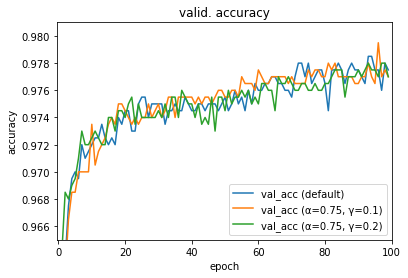

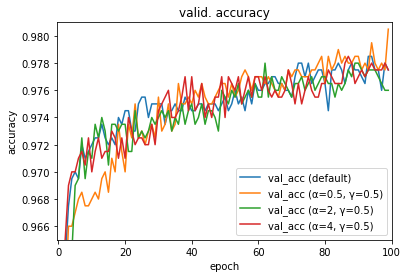

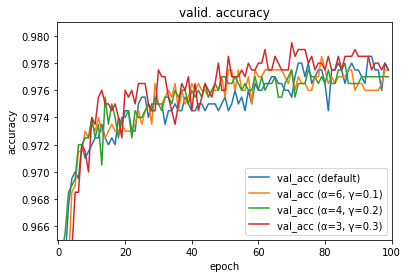

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt

#plt.subplot(1,3,1)
plt.figure(figsize=(6, 4)) 
plt.axis((-0.5,100,0.965,0.981))
plt.plot(val_acc0)
plt.plot(val_acc7)
plt.plot(val_acc5)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=0.75, γ=0.1)', 
            'val_acc (α=0.75, γ=0.2)', 
            ],loc='lower right')  
plt.show()


#plt.subplot(1,3,3)
plt.figure(figsize=(6, 4)) 
plt.axis((-0.5,100,0.965,0.981))
plt.plot(val_acc0)
plt.plot(val_acc4)
plt.plot(val_acc)
plt.plot(val_acc3)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=0.5, γ=0.5)', 
            'val_acc (α=2, γ=0.5)', 
            'val_acc (α=4, γ=0.5)', 
            ],loc='lower right')  

plt.show()

plt.figure(figsize=(6, 4)) 
plt.axis((-0.5,100,0.965,0.981))
plt.plot(val_acc0)
plt.plot(val_acc9)
plt.plot(val_acc10)
plt.plot(val_acc11)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=6, γ=0.1)',
            'val_acc (α=4, γ=0.2)',
            'val_acc (α=3, γ=0.3)',
            ],loc='lower right')  
plt.show()

**Instead, high gamma values result lower accuracy**

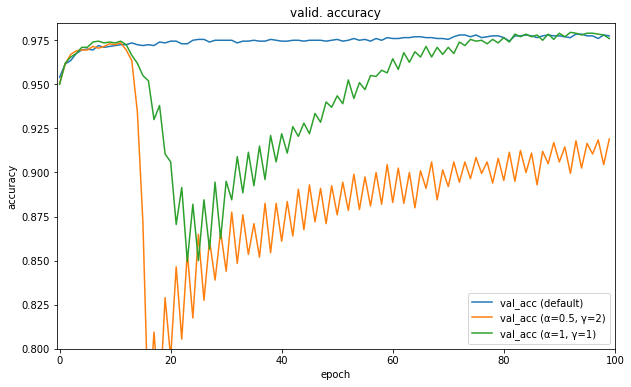

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((-0.5,100,0.8,0.985))


plt.plot(val_acc0)
plt.plot(val_acc6)
plt.plot(val_acc2)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=0.5, γ=2)',
            'val_acc (α=1, γ=1)', 
            ],loc='lower right')  

plt.show()

# Experiment 2: Imbalance data#
11500 dog images and 1000 cat images

In [6]:
from sklearn.metrics import confusion_matrix
import itertools

In [7]:
def plot_confusion_matrix(y_valid, y_pred):
    
    assert len(y_valid) == len(y_pred)
    
    color_labels = ['is_Cat', 'is_Dog']
    num_data = len(y_valid)
    expected_labels = [y_valid[i] for i in range(num_data)]
    predicted_labels = [int(y_pred[i]>0.5) for i in range(num_data)]
    
    cm = confusion_matrix(expected_labels, predicted_labels)
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)    
    plt.colorbar()
    tick_marks = np.arange(len(color_labels))
    plt.xticks(tick_marks, color_labels, rotation=90)
    plt.yticks(tick_marks, color_labels)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return None

In [250]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

## 2A. Binary Cross-entropy Loss##

In [252]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 3e-5
val_acc0 = []

for i in range(60):
    if (i+1) % 30 == 0:
        model.optimizer.lr = model.optimizer.lr/3.
    model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc0.append(get_val_acc(y_valid, y_pred))    

Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 4s - loss: 0.8544 - acc: 0.6044 - val_loss: 0.3000 - val_acc: 0.8990
Epoch 1/100
val_acc: 0.899
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.6662 - acc: 0.7033 - val_loss: 0.2340 - val_acc: 0.9215
Epoch 2/100
val_acc: 0.9215
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.5287 - acc: 0.7716 - val_loss: 0.1966 - val_acc: 0.9430
Epoch 3/100
val_acc: 0.943
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.4404 - acc: 0.8265 - val_loss: 0.1606 - val_acc: 0.9565
Epoch 4/100
val_acc: 0.9565
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.3536 - acc: 0.8730 - val_loss: 0.1449 - val_acc: 0.9635
Epoch 5/100
val

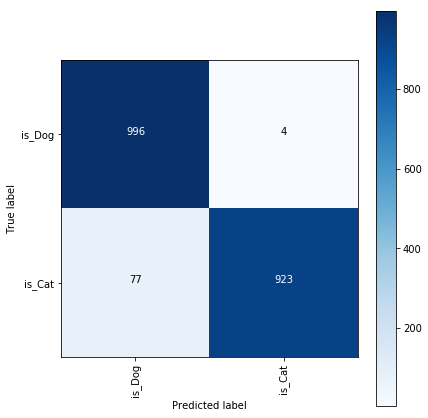

In [253]:
y_pred = model.predict(X_valid, batch_size=batch_size)
plot_confusion_matrix(y_valid, y_pred)

In [167]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

## 2B. Focal Loss##

In [ ]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 3e-5

val_acc11 = []
w_FL = None

for i in range(60):
    if i <= 4:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 30 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=3, gamma=0.3)
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/60')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc11.append(get_val_acc(y_valid, y_pred))

Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 4s - loss: 0.8235 - acc: 0.6046 - val_loss: 0.3450 - val_acc: 0.8500
Epoch 1/60
val_acc: 0.85
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.6256 - acc: 0.7118 - val_loss: 0.2515 - val_acc: 0.9165
Epoch 2/60
val_acc: 0.9165
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.5152 - acc: 0.7836 - val_loss: 0.2035 - val_acc: 0.9495
Epoch 3/60
val_acc: 0.9495
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.4081 - acc: 0.8366 - val_loss: 0.1696 - val_acc: 0.9595
Epoch 4/60
val_acc: 0.9595
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.3430 - acc: 0.8820 - val_loss: 0.1438 - val_acc: 0.9665
Epoch 5/60
val_acc:

In [ ]:
y_pred = model.predict(X_valid, batch_size=batch_size)
plot_confusion_matrix(y_valid, y_pred)

In [221]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-5

val_acc10 = []
w_FL = None

for i in range(100):
    if i <= 4:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 30 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=1, gamma=1)
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/100')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc10.append(get_val_acc(y_valid, y_pred))

Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 3s - loss: 0.9035 - acc: 0.5704 - val_loss: 0.3736 - val_acc: 0.8595
Epoch 1/100
val_acc: 0.8595
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.8017 - acc: 0.6227 - val_loss: 0.3141 - val_acc: 0.8795
Epoch 2/100
val_acc: 0.8795
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.7339 - acc: 0.6553 - val_loss: 0.2882 - val_acc: 0.8905
Epoch 3/100
val_acc: 0.8905
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.6895 - acc: 0.6854 - val_loss: 0.2677 - val_acc: 0.9045
Epoch 4/100
val_acc: 0.9045
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.6531 - acc: 0.7030 - val_loss: 0.2515 - val_acc: 0.9115
Epoch 5/100
v

12500/12500 [==============================] - 1s - loss: 0.0283 - acc: 0.9449 - val_loss: 0.1290 - val_acc: 0.9615
Epoch 41/100
val_acc: 0.9615
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.0275 - acc: 0.9474 - val_loss: 0.1309 - val_acc: 0.9590
Epoch 42/100
val_acc: 0.959
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.0251 - acc: 0.9502 - val_loss: 0.1270 - val_acc: 0.9615
Epoch 43/100
val_acc: 0.9615
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.0260 - acc: 0.9538 - val_loss: 0.1299 - val_acc: 0.9585
Epoch 44/100
val_acc: 0.9585
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 1s - loss: 0.0261 - acc: 0.9546 - val_loss: 0.1244 - val_acc: 0.9620
Epoch 45/100
val_acc: 0.962
Train on 12500 samples, validate on 2000 

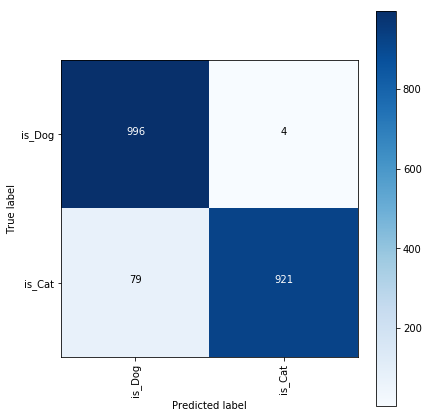

In [222]:
y_pred = model.predict(X_valid, batch_size=batch_size)
plot_confusion_matrix(y_valid, y_pred)

In [ ]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 3e-5

val_acc9 = []
w_FL = None

for i in range(60):
    if i <= 4:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 30 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=1, gamma=1)
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/60')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc9.append(get_val_acc(y_valid, y_pred))

Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 4s - loss: 0.8641 - acc: 0.6030 - val_loss: 0.2913 - val_acc: 0.8965
Epoch 1/60
val_acc: 0.8965
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.6547 - acc: 0.6994 - val_loss: 0.2242 - val_acc: 0.9345
Epoch 2/60
val_acc: 0.9345
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.5305 - acc: 0.7737 - val_loss: 0.1929 - val_acc: 0.9495
Epoch 3/60
val_acc: 0.9495
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.4331 - acc: 0.8310 - val_loss: 0.1609 - val_acc: 0.9660
Epoch 4/60
val_acc: 0.966
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.3650 - acc: 0.8690 - val_loss: 0.1420 - val_acc: 0.9700
Epoch 5/60
val_acc

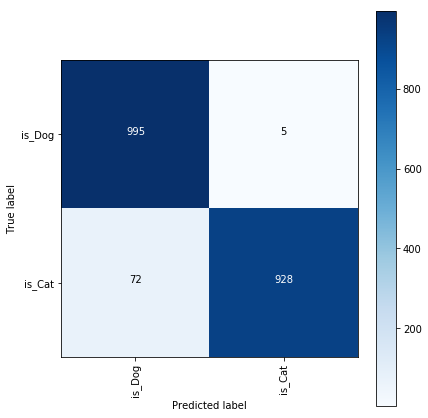

In [219]:
y_pred = model.predict(X_valid, batch_size=batch_size)
plot_confusion_matrix(y_valid, y_pred)

In [249]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 3e-5

val_acc8 = []
w_FL = None

for i in range(60):
    if i <= 4:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 30 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=0.5, gamma=2)
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/60')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc8.append(get_val_acc(y_valid, y_pred))

Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 4s - loss: 0.8202 - acc: 0.6122 - val_loss: 0.3224 - val_acc: 0.8690
Epoch 1/60
val_acc: 0.869
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.6502 - acc: 0.7015 - val_loss: 0.2541 - val_acc: 0.9255
Epoch 2/60
val_acc: 0.9255
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.5193 - acc: 0.7788 - val_loss: 0.2045 - val_acc: 0.9515
Epoch 3/60
val_acc: 0.9515
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.4213 - acc: 0.8386 - val_loss: 0.1721 - val_acc: 0.9595
Epoch 4/60
val_acc: 0.9595
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.3572 - acc: 0.8772 - val_loss: 0.1537 - val_acc: 0.9635
Epoch 5/60
val_acc

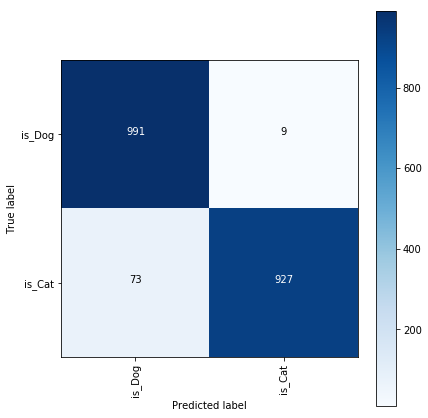

In [217]:
y_pred = model.predict(X_valid, batch_size=batch_size)
plot_confusion_matrix(y_valid, y_pred)

In [244]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 1000]
y_train_imb = y_train[:23000//2 + 1000]

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 3e-5

val_acc7 = []
w_FL = None

for i in range(60):
    if i <= 4:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 30 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=5, gamma=2)
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/60')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc7.append(get_val_acc(y_valid, y_pred))

Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 4s - loss: 0.8260 - acc: 0.6045 - val_loss: 0.3383 - val_acc: 0.8660
Epoch 1/60
val_acc: 0.866
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.6435 - acc: 0.7101 - val_loss: 0.2768 - val_acc: 0.9050
Epoch 2/60
val_acc: 0.905
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.5222 - acc: 0.7785 - val_loss: 0.2283 - val_acc: 0.9320
Epoch 3/60
val_acc: 0.932
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.4258 - acc: 0.8342 - val_loss: 0.1919 - val_acc: 0.9490
Epoch 4/60
val_acc: 0.949
Train on 12500 samples, validate on 2000 samples
Epoch 1/1
12500/12500 [==============================] - 2s - loss: 0.3561 - acc: 0.8735 - val_loss: 0.1659 - val_acc: 0.9585
Epoch 5/60
val_acc: 0

In [ ]:
y_pred = model.predict(X_valid, batch_size=batch_size)
plot_confusion_matrix(y_valid, y_pred)

## 2C. Experiment 2 Result##

No improvement when gamma is small, but can achieve higher acc. when gamma is high

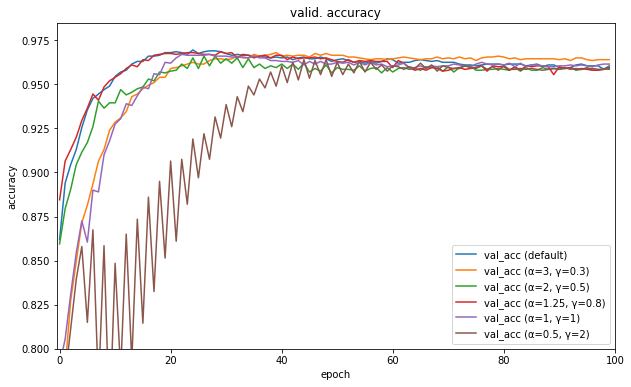

In [231]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((-0.5,100,0.8,0.985))


plt.plot(val_acc0)
plt.plot(val_acc11)
plt.plot(val_acc10)
plt.plot(val_acc9)
plt.plot(val_acc8)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=3, γ=0.3)',
            'val_acc (α=2, γ=0.5)', 
            'val_acc (α=1, γ=1)',
            'val_acc (α=0.5, γ=2)',
            ],loc='lower right')  

plt.show()

Zoomed-in

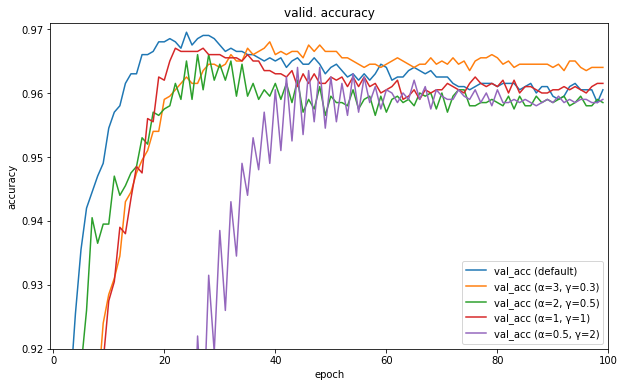

In [243]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((-0.5,100,0.92,0.971))


plt.plot(val_acc0)
plt.plot(val_acc11)
plt.plot(val_acc10)
plt.plot(val_acc9)
plt.plot(val_acc8)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=3, γ=0.3)',
            'val_acc (α=2, γ=0.5)', 
            'val_acc (α=1, γ=1)',
            'val_acc (α=0.5, γ=2)',
            ],loc='lower right')  

plt.show()

** Achieve higher accuracy when gamma is high**

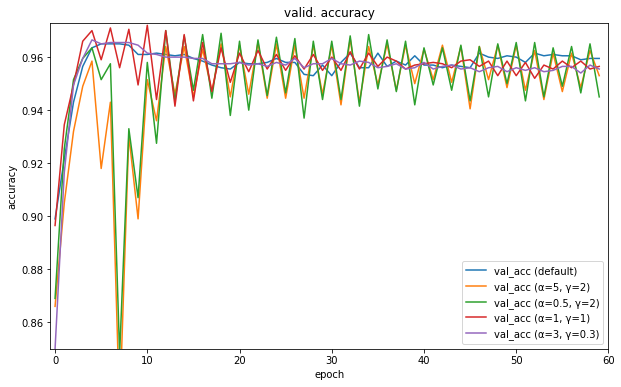

In [263]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((-0.5,60,0.85,0.973))


plt.plot(val_acc0)
plt.plot(val_acc7)
plt.plot(val_acc8)
plt.plot(val_acc9)
plt.plot(val_acc11)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=5, γ=2)',
            'val_acc (α=0.5, γ=2)',
            'val_acc (α=1, γ=1)',
            'val_acc (α=3, γ=0.3)',
            ],loc='lower right')  

plt.show()

Steady state zoomed-in

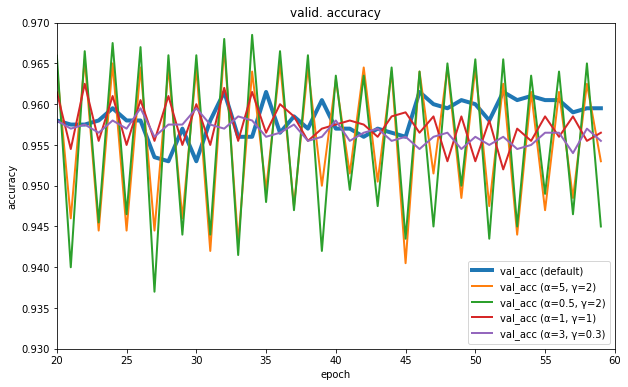

In [283]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((20,60,0.93,0.97))


plt.plot(val_acc0, linewidth=4.0)
plt.plot(val_acc7, linewidth=2.0)
plt.plot(val_acc8, linewidth=2.0)
plt.plot(val_acc9, linewidth=2.0)
plt.plot(val_acc11, linewidth=2.0)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (α=5, γ=2)',
            'val_acc (α=0.5, γ=2)',
            'val_acc (α=1, γ=1)',
            'val_acc (α=3, γ=0.3)',
            ],loc='lower right')  

plt.show()

# Experiment 3: Imbalance data (100:1)
11500 cat images and 115 dog images

## 3A. Binary Cross-entropy Loss##

In [9]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 115]
y_train_imb = y_train[:23000//2 + 115]
#X_valid = np.concatenate([X_valid, X_train[23000//2 + 115:]], axis=0)
#y_valid = np.concatenate([y_valid, y_train[23000//2 + 115:]], axis=0)

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-4
val_acc0 = []

for i in range(61):
    if (i+1) % 20 == 0:
        model.optimizer.lr = model.optimizer.lr/3.
    model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    print ('Epoch '+str(i+1)+'/60')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc0.append(get_val_acc(y_valid, y_pred))   

Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 8.6612 - acc: 0.5442 - val_loss: 7.3388 - val_acc: 0.8165
Epoch 1/60
val_acc: 0.8165
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 7.3397 - acc: 0.6203 - val_loss: 6.3238 - val_acc: 0.9155
Epoch 2/60
val_acc: 0.9155
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 6.3475 - acc: 0.6889 - val_loss: 5.5521 - val_acc: 0.9385
Epoch 3/60
val_acc: 0.9385
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 5.5689 - acc: 0.7408 - val_loss: 4.9926 - val_acc: 0.9160
Epoch 4/60
val_acc: 0.916
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 4.9021 - acc: 0.7902 - val_loss: 4.4448 - val_acc: 0.9150
Epoch 5/60
val_acc

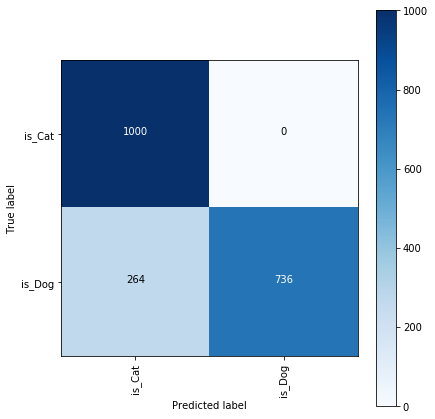

In [10]:
y_pred = model.predict(X_valid, batch_size=batch_size*2)
plot_confusion_matrix(y_valid, y_pred)

## 3B. Focal Loss##

gamma value is adaptive

In [54]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 115]
y_train_imb = y_train[:23000//2 + 115]
X_valid = np.concatenate([X_valid, X_train[23000//2 + 115:]],axis=0)
y_valid = np.concatenate([y_valid, y_train[23000//2 + 115:]],axis=0)

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 3e-5

val_acc7 = []
cw = {'0': 1., '1': 3.}
w_FL = None

for i in range(60):
    if i <= 9:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 20 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=1, gamma=0.1*(i/2))
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/60')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc7.append(get_val_acc(y_valid, y_pred))

Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 3s - loss: 9.2136 - acc: 0.5186 - val_loss: 8.3898 - val_acc: 0.6379
Epoch 1/60
val_acc: 0.6378782218901756
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 8.7092 - acc: 0.5328 - val_loss: 7.8201 - val_acc: 0.7993
Epoch 2/60
val_acc: 0.799252895031752
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 8.2442 - acc: 0.5629 - val_loss: 7.3923 - val_acc: 0.8480
Epoch 3/60
val_acc: 0.848038849458349
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 7.8428 - acc: 0.5852 - val_loss: 7.0415 - val_acc: 0.8721
Epoch 4/60
val_acc: 0.8720956294359358
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 7.4830 - acc: 0.6049 - v

Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.8283 - acc: 0.8551 - val_loss: 0.8398 - val_acc: 0.9721
Epoch 39/60
val_acc: 0.9720582741875233
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.7564 - acc: 0.8155 - val_loss: 4.4866 - val_acc: 0.1992
Epoch 40/60
val_acc: 0.19917818453492717
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.6995 - acc: 0.8555 - val_loss: 0.7097 - val_acc: 0.9762
Epoch 41/60
val_acc: 0.9762420620097124
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.6381 - acc: 0.8303 - val_loss: 4.0386 - val_acc: 0.2566
Epoch 42/60
val_acc: 0.25663055659320133
Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.5873 - acc: 0.

In [60]:
y = model.predict(X_train_imb, batch_size=batch_size)
w_FL = get_FL_weights(y, y_train_imb, alpha=1, gamma=1.5)
X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
          sample_weight=w_FL, shuffle = False)

Train on 11615 samples, validate on 13385 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.1578 - acc: 0.8382 - val_loss: 0.2262 - val_acc: 0.9705


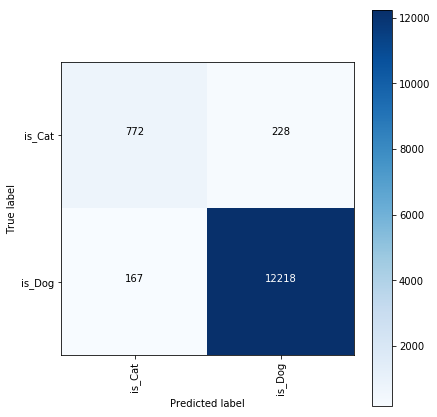

In [61]:
y_pred = model.predict(X_valid, batch_size=batch_size*2)
plot_confusion_matrix(y_valid, y_pred)

In [11]:
X_train = []
X_valid = []
X_test = []

for filename in ["gap_ResNet50.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_valid.append(np.array(h['valid']))
        y_train = np.array(h['label'])
        y_valid = np.array(h['val_label'])

X_train = np.concatenate(X_train, axis=1)
X_valid = np.concatenate(X_valid, axis=1)

X_train_imb = X_train[:23000//2 + 115]
y_train_imb = y_train[:23000//2 + 115]
#X_valid = np.concatenate([X_valid, X_train[23000//2 + 115:]],axis=0)
#y_valid = np.concatenate([y_valid, y_train[23000//2 + 115:]],axis=0)

input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x) # this should be relu
x = BatchNormalization()(x)
x = Dropout(0.75)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.optimizer.lr = 1e-4

val_acc8 = []
cw = {'0': 1., '1': 3.}
w_FL = None

for i in range(61):
    if i <= 9:
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid))
    else:
        if i % 20 == 0:
            model.optimizer.lr = model.optimizer.lr/3.
        y = model.predict(X_train_imb, batch_size=batch_size)
        w_FL = get_FL_weights(y, y_train_imb, alpha=0.5, gamma=0.1*(i/2))
        X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
        model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
                  sample_weight=w_FL, shuffle = False)
    print ('Epoch '+str(i+1)+'/61')
    y_pred = model.predict(X_valid, batch_size=batch_size)
    val_acc8.append(get_val_acc(y_valid, y_pred))

Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 8.7590 - acc: 0.5463 - val_loss: 7.4515 - val_acc: 0.8415
Epoch 1/61
val_acc: 0.8415
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 7.4845 - acc: 0.6202 - val_loss: 6.4571 - val_acc: 0.9135
Epoch 2/61
val_acc: 0.9135
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 6.5152 - acc: 0.6872 - val_loss: 5.7219 - val_acc: 0.9245
Epoch 3/61
val_acc: 0.9245
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 5.7278 - acc: 0.7428 - val_loss: 5.1601 - val_acc: 0.8885
Epoch 4/61
val_acc: 0.8885
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 5.0735 - acc: 0.7927 - val_loss: 4.6095 - val_acc: 0.9020
Epoch 5/61
val_ac

In [15]:
y = model.predict(X_train_imb, batch_size=batch_size)
w_FL = get_FL_weights(y, y_train_imb, alpha=1, gamma=2)
X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
          sample_weight=w_FL, shuffle = False)
y = model.predict(X_train_imb, batch_size=batch_size)
w_FL = get_FL_weights(y, y_train_imb, alpha=1, gamma=2)
X_train_imb, y_train_imb, w_FL = shuffle(X_train_imb, y_train_imb, w_FL)
model.fit(X_train_imb, y_train_imb, batch_size=batch_size*2, epochs=1, validation_data=(X_valid,y_valid), 
          sample_weight=w_FL, shuffle = False)

Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.0731 - acc: 0.9231 - val_loss: 4.2561 - val_acc: 0.4780
Train on 11615 samples, validate on 2000 samples
Epoch 1/1
11615/11615 [==============================] - 1s - loss: 0.0643 - acc: 0.9420 - val_loss: 0.1918 - val_acc: 0.9490


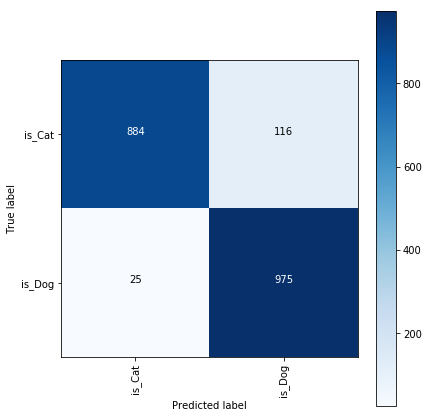

In [75]:
y_pred = model.predict(X_valid, batch_size=batch_size*2)
plot_confusion_matrix(y_valid, y_pred)

## 3C. Experiment 3 Results##

** alpha=1, gamma is adaptive**

gamma=(i/20) for i-th epoch

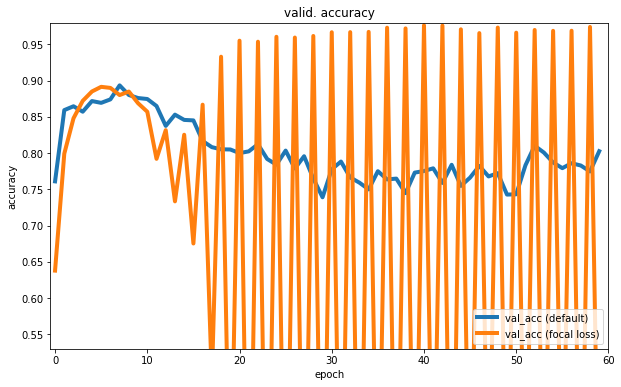

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((-0.5,60,0.53,0.98))


plt.plot(val_acc0, linewidth=4.0)
plt.plot(val_acc7, linewidth=4.0)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (focal loss)',
            ],loc='lower right')  

plt.show()

** alpha=0.5, gamma is adaptive**

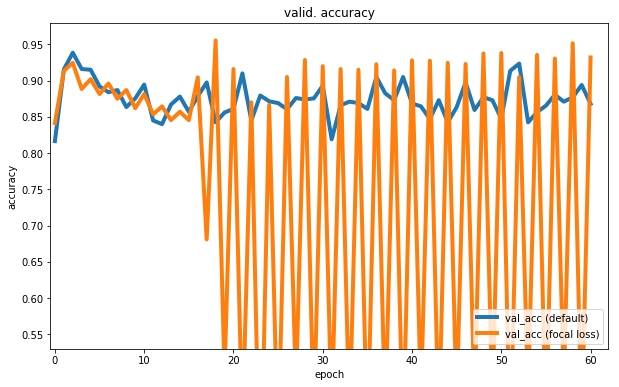

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6)) 
plt.axis((-0.5,62,0.53,0.98))


plt.plot(val_acc0, linewidth=4.0)
plt.plot(val_acc8, linewidth=4.0)

plt.title('valid. accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['val_acc (default)', 
            'val_acc (focal loss)',
            ],loc='lower right')  

plt.show()